# Notebook 1: Data Retrieval from FDB and Preprocessing

This notebook serves as a guide to accessing data from FDB (Fields Database) object storage and preprocessing. In the first part, it demonstrates the computation of median ensembles of precipitations aggregated over 6 hours, followed by a more complex computational process, the computation of potential vorticity.

https://github.com/MeteoSwiss/meteodata-lab

## Accessing Data from FDB

To access the data from FDB, follow these steps:

### Configuring Access to FDB

In [1]:
import logging
import os
import sys
from pathlib import Path

from meteodatalab import mars, mch_model_data

import plot_utils

In [2]:
logging.basicConfig(level=logging.INFO, stream=sys.stdout)
logging.getLogger("matplotlib").setLevel(logging.INFO)
cwd = Path().resolve().parent
view = cwd / "spack-env/.spack-env/view"
assert view.exists()

In [3]:
os.environ["FDB5_HOME"] = str(view)
os.environ["FDB5_CONFIG"] = """
---
type: remote
engine: remote
host: balfrin-ln003.cscs.ch
port: 30005
store: remote
"""
os.environ["FDB_REMOTE_RETRIEVE_QUEUE_LENGTH"] = "100"

### Retrieving Data

Use query functions to retrieve the required data.

The request for data is made by specifying the values of MARS keys.
MARS keys are derived from GRIB keys and serve as a base for the FDB index.
The `meteodatalab.mars` module provides helpers to build valid MARS request in the context of MeteoSwiss.

Note that the available data in the test FDB instance is typically limited to the 2 latest forecasts so the date and time may need to be adapted accordingly.

In [4]:
request = mars.Request(
    param="TOT_PREC",
    date="20240409",
    time="1800",
    number=tuple(range(11)),
    step=tuple(i * 60 for i in range(10)),  # minutes
    levtype=mars.LevType.SURFACE,
    model=mars.Model.ICON_CH1_EPS,
)

In [5]:
request.to_fdb()

{'param': 500041,
 'date': '20240409',
 'time': '1800',
 'expver': '0001',
 'number': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'step': [0, 60, 120, 180, 240, 300, 360, 420, 480, 540],
 'class': 'od',
 'levtype': 'sfc',
 'model': 'ICON-CH1-EPS',
 'stream': 'enfo',
 'type': 'ememb'}

The `meteodatalab.mch_model_data` module provides some convenience functions to access model data.
Earthkit-data is used in the background to read the data that is being returned by FDB.

In [6]:
ds = mch_model_data.get_from_fdb(request)

INFO:meteodatalab.mch_model_data:Getting request Request(param='TOT_PREC', date='20240409', time='1800', expver='0001', levelist=None, number=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10), step=(0, 60, 120, 180, 240, 300, 360, 420, 480, 540), class_=<Class.OPERATIONAL_DATA: 'od'>, levtype='sfc', model='ICON-CH1-EPS', stream=<Stream.ENS_FORECAST: 'enfo'>, type=<Type.ENS_MEMBER: 'ememb'>, feature=None) from FDB.
INFO:meteodatalab.grib_decoder:Retrieving request: Request(param='TOT_PREC', date='20240409', time='1800', expver='0001', levelist=None, number=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10), step=(0, 60, 120, 180, 240, 300, 360, 420, 480, 540), class_=<Class.OPERATIONAL_DATA: 'od'>, levtype='sfc', model='ICON-CH1-EPS', stream=<Stream.ENS_FORECAST: 'enfo'>, type=<Type.ENS_MEMBER: 'ememb'>, feature=None)


The data is returned as dictionary of xarray DataArrays where the keys are set to the param short name.

In [7]:
ds["TOT_PREC"]

<xarray.DataArray (eps: 11, time: 10, y: 786, x: 1170)> Size: 405MB
array([[[[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ]],

        [[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
...
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ]],

        [[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ]]]], dtype=float32)
Coordinates:
  * eps         (eps) int64 88B 0 1 2 3 4 5 6 7 8 9 10
  * time        (time) int64 80B 0 60 120 180 240 300 360 420 480 540
    lat         (y, x) float64 7MB 42.14 42.14 42.14 42.14 ... 50.16 50.16 50.16
    lon         (y, x) float64 7MB 0.7593 0.7726 0.786 ... 17.51 17.52 17.54
    valid_time  (time) datetime64[ns] 80B 2024-04-09T18:00:00 ... 2024-04-10T...
    ref_time    datetime64[ns] 8B 2024-04-09T18:00:00
Dimensions without coordinates: y, x
Attributes:
    message:      b"GRIB\xff\xff\x00\x02\x00\x00\x00\x00\x00\x00\x00\xf8\x00\...
    parameter:    {'centre': 'lssw', 'paramId': 500041, 'shortName': 'TOT_PRE...
    geography:    {'Ni': 1170, 'Nj': 786, 'iScansNegatively': 0, 'jScansPosit...
    vref:         geo
    vcoord_type:  surface
    origin_z:     0.0

## Data Preprocessing for Computing Median Ensembles

Before computing median ensembles aggregated over 6 hours, ensure the data undergoes appropriate preprocessing:

### Data Aggregation
Aggregate data over 6-hour intervals.

`meteodatalab` implements operators that transform the data. 

For example, the total precipitation is accumulated from the reference time but reaggregated to 6 hour intervals using the `delta` operator.

In [8]:
import numpy as np
from meteodatalab.operators import time_operators as time_ops

In [9]:
tot_prec_6h = time_ops.delta(ds["TOT_PREC"], np.timedelta64(6, "h"))

In [10]:
tot_prec_6h

<xarray.DataArray (eps: 11, time: 10, y: 786, x: 1170)> Size: 405MB
array([[[[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         ...,
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan]],

        [[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
...
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ]],

        [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         ...,
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ]]]], dtype=float32)
Coordinates:
  * eps         (eps) int64 88B 0 1 2 3 4 5 6 7 8 9 10
  * time        (time) int64 80B 0 60 120 180 240 300 360 420 480 540
    lat         (y, x) float64 7MB 42.14 42.14 42.14 42.14 ... 50.16 50.16 50.16
    lon         (y, x) float64 7MB 0.7593 0.7726 0.786 ... 17.51 17.52 17.54
    valid_time  (time) datetime64[ns] 80B 2024-04-09T18:00:00 ... 2024-04-10T...
    ref_time    datetime64[ns] 8B 2024-04-09T18:00:00
Dimensions without coordinates: y, x
Attributes:
    message:      b"GRIB\xff\xff\x00\x02\x00\x00\x00\x00\x00\x00\x00\xf8\x00\...
    parameter:    {'centre': 'lssw', 'paramId': 500041, 'shortName': 'TOT_PRE...
    geography:    {'Ni': 1170, 'Nj': 786, 'iScansNegatively': 0, 'jScansPosit...
    vref:         geo
    vcoord_type:  surface
    origin_z:     0.0

### Ensemble Calculation

Compute median ensembles using preprocessed data.

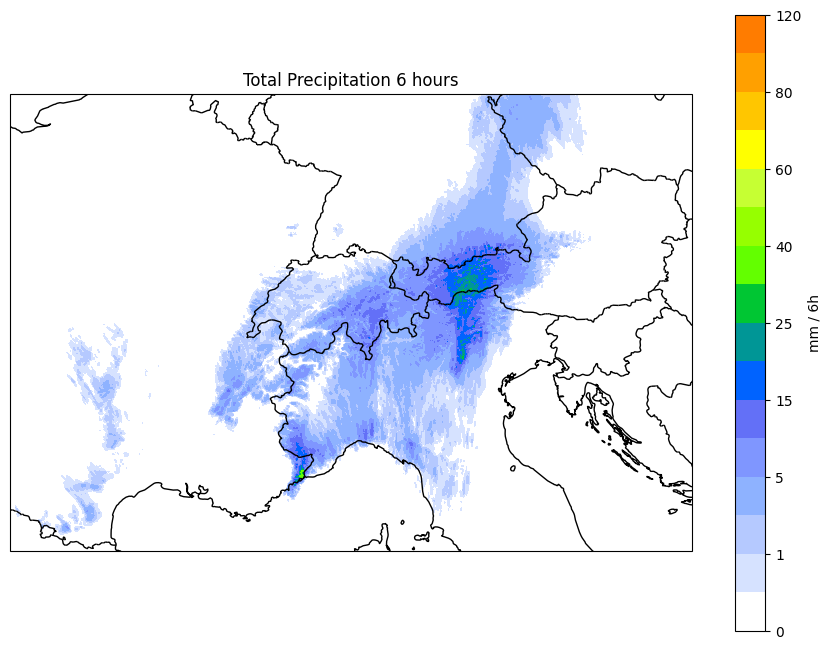

In [11]:
data = tot_prec_6h.isel(time=8).median(dim="eps").clip(min=0)
data.attrs["geography"] = tot_prec_6h.geography
plot_utils.plot_tot_prec(data)

## Potential Vorticity Calculation and Wind Field Rotation

This notebook introduces a comprehensive approach to computing potential vorticity (PV) and rotating the wind field, representing a more intricate computational process compared to Notebook 1, which primarily focused on straightforward data retrieval and preprocessing.

### Querying Data

Utilize query functions to smoothly retrieve the nine required fields spanning all model levels.

In [12]:
request = mars.Request(
    param=("P", "T", "U", "V", "W", "QV", "QC", "QI"),
    date="20240419",
    time="1200",
    number=0,
    step=420,
    levtype=mars.LevType.MODEL_LEVEL,
    levelist=tuple(range(1, 82)),
    model=mars.Model.ICON_CH1_EPS,
)

In [13]:
request_hhl_const = mars.Request(
    param="HHL",
    date="20240419",
    time="1200",
    number=0,
    step=0,
    levtype=mars.LevType.MODEL_LEVEL,
    levelist=tuple(range(1, 82)),
    model=mars.Model.ICON_CH1_EPS,
)

In [14]:
ds = mch_model_data.get_from_fdb(request)

INFO:meteodatalab.mch_model_data:Getting request Request(param=('P', 'T', 'U', 'V', 'W', 'QV', 'QC', 'QI'), date='20240419', time='1200', expver='0001', levelist=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81), number=0, step=420, class_=<Class.OPERATIONAL_DATA: 'od'>, levtype='ml', model='ICON-CH1-EPS', stream=<Stream.ENS_FORECAST: 'enfo'>, type=<Type.ENS_MEMBER: 'ememb'>, feature=None) from FDB.
INFO:meteodatalab.grib_decoder:Retrieving request: Request(param=('P', 'T', 'U', 'V', 'W', 'QV', 'QC', 'QI'), date='20240419', time='1200', expver='0001', levelist=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,

In [15]:
ds |= mch_model_data.get_from_fdb(request_hhl_const)

INFO:meteodatalab.mch_model_data:Getting request Request(param='HHL', date='20240419', time='1200', expver='0001', levelist=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81), number=0, step=0, class_=<Class.OPERATIONAL_DATA: 'od'>, levtype='ml', model='ICON-CH1-EPS', stream=<Stream.ENS_FORECAST: 'enfo'>, type=<Type.ENS_MEMBER: 'ememb'>, feature=None) from FDB.
INFO:meteodatalab.grib_decoder:Retrieving request: Request(param='HHL', date='20240419', time='1200', expver='0001', levelist=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 6

In [16]:
hhl = ds["HHL"].squeeze(drop=True)
hhl

<xarray.DataArray (z: 81, y: 786, x: 1170)> Size: 298MB
array([[[ 2.2000000e+04,  2.2000000e+04,  2.2000000e+04, ...,
          2.2000000e+04,  2.2000000e+04,  2.2000000e+04],
        [ 2.2000000e+04,  2.2000000e+04,  2.2000000e+04, ...,
          2.2000000e+04,  2.2000000e+04,  2.2000000e+04],
        [ 2.2000000e+04,  2.2000000e+04,  2.2000000e+04, ...,
          2.2000000e+04,  2.2000000e+04,  2.2000000e+04],
        ...,
        [ 2.2000000e+04,  2.2000000e+04,  2.2000000e+04, ...,
          2.2000000e+04,  2.2000000e+04,  2.2000000e+04],
        [ 2.2000000e+04,  2.2000000e+04,  2.2000000e+04, ...,
          2.2000000e+04,  2.2000000e+04,  2.2000000e+04],
        [ 2.2000000e+04,  2.2000000e+04,  2.2000000e+04, ...,
          2.2000000e+04,  2.2000000e+04,  2.2000000e+04]],

       [[ 1.9808365e+04,  1.9808365e+04,  1.9808365e+04, ...,
          1.9808365e+04,  1.9808365e+04,  1.9808365e+04],
        [ 1.9808365e+04,  1.9808365e+04,  1.9808365e+04, ...,
          1.9808365e+04,  1.9808365e+04,  1.9808365e+04],
        [ 1.9808365e+04,  1.9808365e+04,  1.9808365e+04, ...,
          1.9808365e+04,  1.9808365e+04,  1.9808365e+04],
...
        [ 2.0026630e+01,  2.0026630e+01,  2.0026630e+01, ...,
          7.1502661e+02,  6.8252661e+02,  6.0065161e+02],
        [ 2.0026630e+01,  2.0026630e+01,  2.0026630e+01, ...,
          6.4652661e+02,  6.9602661e+02,  6.8440161e+02],
        [ 2.0026630e+01,  2.0026630e+01,  2.0026630e+01, ...,
          5.4290161e+02,  6.7440161e+02,  6.7690161e+02]],

       [[ 7.8660376e+02,  8.0422876e+02,  9.6722876e+02, ...,
         -2.1212578e-02, -2.1212578e-02, -2.1212578e-02],
        [ 9.2235376e+02,  8.7072876e+02,  9.1822876e+02, ...,
         -2.1212578e-02, -2.1212578e-02, -2.1212578e-02],
        [ 9.5797876e+02,  9.7822876e+02,  9.7085376e+02, ...,
         -2.1212578e-02, -2.1212578e-02, -2.1212578e-02],
        ...,
        [-2.1212578e-02, -2.1212578e-02, -2.1212578e-02, ...,
          6.9510376e+02,  6.6247876e+02,  5.8072876e+02],
        [-2.1212578e-02, -2.1212578e-02, -2.1212578e-02, ...,
          6.2647876e+02,  6.7597876e+02,  6.6435376e+02],
        [-2.1212578e-02, -2.1212578e-02, -2.1212578e-02, ...,
          5.2297876e+02,  6.5435376e+02,  6.5697876e+02]]], dtype=float32)
Coordinates:
  * z         (z) int64 648B 1 2 3 4 5 6 7 8 9 10 ... 73 74 75 76 77 78 79 80 81
    lat       (y, x) float64 7MB 42.14 42.14 42.14 42.14 ... 50.16 50.16 50.16
    lon       (y, x) float64 7MB 0.7593 0.7726 0.786 ... 17.51 17.52 17.54
    ref_time  datetime64[ns] 8B 2024-04-19T12:00:00
Dimensions without coordinates: y, x
Attributes:
    message:      b"GRIB\xff\xff\x00\x02\x00\x00\x00\x00\x00\x00\x00\xf8\x00\...
    parameter:    {'centre': 'lssw', 'paramId': 500008, 'shortName': 'HHL', '...
    geography:    {'Ni': 1170, 'Nj': 786, 'iScansNegatively': 0, 'jScansPosit...
    vref:         geo
    vcoord_type:  model_level
    origin_z:     -0.5

### Computing Potential Vorticity

The next Jupyter cell will tackle the computation of potential vorticity, a more complex process that isn't directly computed by the model.

In [17]:
from meteodatalab import metadata
from meteodatalab.operators.rho import compute_rho_tot
from meteodatalab.operators.theta import compute_theta
from meteodatalab.operators.pot_vortic import compute_pot_vortic

In [18]:
theta = compute_theta(ds["P"], ds["T"])
rho_tot = compute_rho_tot(ds["T"], ds["P"], ds["QV"], ds["QC"], ds["QI"])

metadata.set_origin_xy(ds, "HHL")
pot_vortic = compute_pot_vortic(ds["U"], ds["V"], ds["W"], theta, rho_tot, hhl)

### Interpolate to potential temperature levels

It's possible to interpolate the potential vorticity on isotherms of potential temperature.

In [19]:
from meteodatalab.operators.destagger import destagger
from meteodatalab.operators.vertical_interpolation import interpolate_k2theta

In [20]:
hfl = destagger(hhl, "z")
theta_values = [310.0, 315.0, 320.0, 325.0, 330.0, 335.0]
pot_vortic_th = interpolate_k2theta(pot_vortic, "low_fold", theta, theta_values, "K", hfl)

In [21]:
pot_vortic_th.coords

Coordinates:
  * eps         (eps) int64 8B 0
  * time        (time) int64 8B 420
    lat         (y, x) float64 7MB 42.14 42.14 42.14 42.14 ... 50.16 50.16 50.16
    lon         (y, x) float64 7MB 0.7593 0.7726 0.786 ... 17.51 17.52 17.54
    valid_time  (time) datetime64[ns] 8B 2024-04-19T19:00:00
    ref_time    datetime64[ns] 8B 2024-04-19T12:00:00
  * theta       (theta) float64 48B 310.0 315.0 320.0 325.0 330.0 335.0

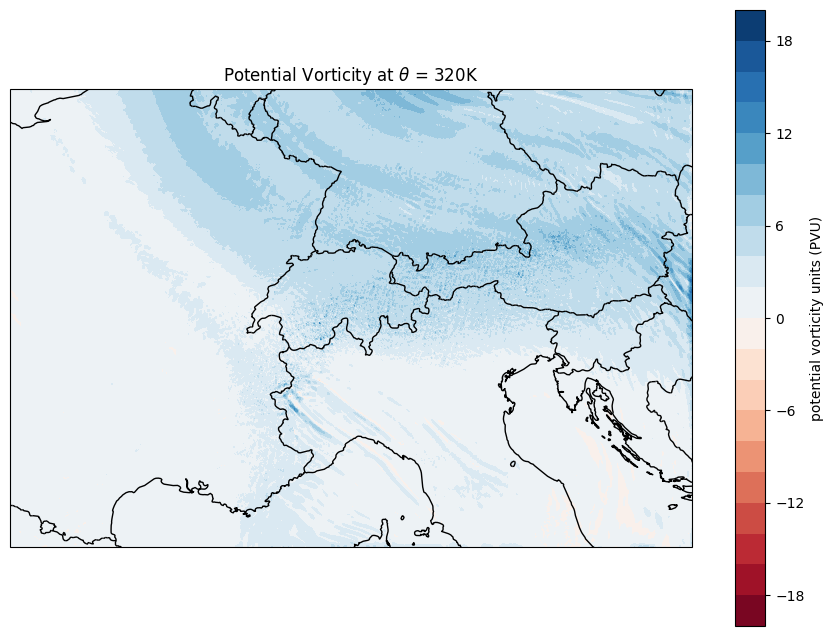

In [22]:
plot_utils.plot_pot_vortic(pot_vortic_th.sel(theta=320), hhl.geography, "Potential Vorticity at $\\theta$ = 320K")

### Compute the mean between pressure levels

There's also an option to compute the mean potential vorticity between two isobars (or pressure levels).

In [23]:
from meteodatalab.operators.vertical_interpolation import interpolate_k2p
from meteodatalab.operators.vertical_reduction import integrate_k

In [24]:
isobars = interpolate_k2p(hfl, "linear_in_lnp", ds["P"], [700, 900], "hPa")
h700, h900 = isobars.transpose("pressure", ...)
pot_vortic_mean = integrate_k(pot_vortic, "normed_integral", "z2z", hhl, (h900, h700))

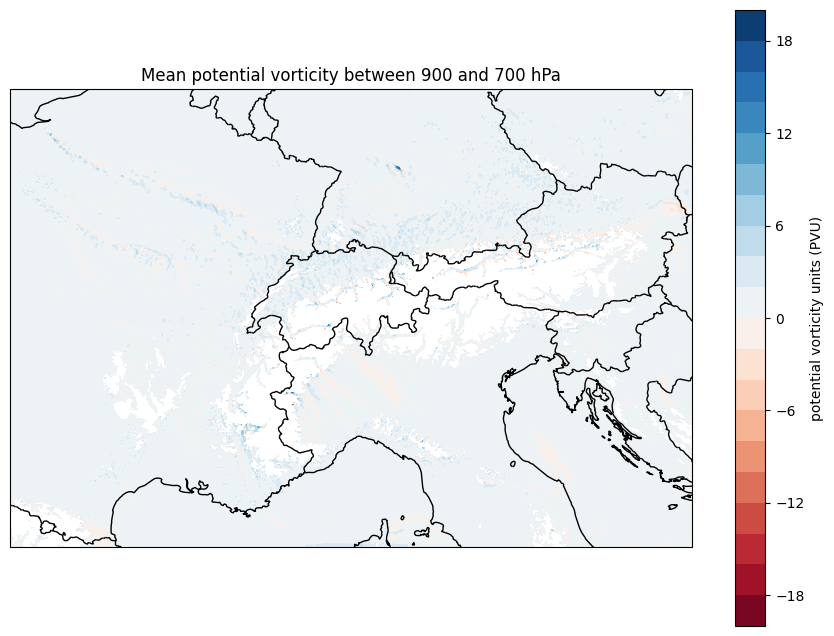

In [25]:
plot_utils.plot_pot_vortic(pot_vortic_mean, hhl.geography, "Mean potential vorticity between 900 and 700 hPa")

## Summary

- retrieve data from FDB in python
- GRIB data read into xarray
- meteorological operators that are aware of the grib metadata
- the GRIB metadata is kept consistent throughout operations